## 2.6 Usar modelos generativos para classificação de sentimento

In [ ]:
!pip install openai python-dotenv pandas transformers accelerate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 22.1 MB/s eta 0:00:0000:0100:01


### Bibliotecas

In [ ]:
import os
import time
import csv
import hashlib
import random
from openai import OpenAI
from dotenv import load_dotenv
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
from transformers import pipeline
from sklearn.metrics import accuracy_score

### Modelo Perplexity

#### API KEY

In [ ]:
# Definir a API
os.environ["PERPLEXITY_API_KEY"] = "XXXXXXXXXXXXXXX"

#### Modelo

In [ ]:
# Carregar as variáveis de ambiente do ficheiro .env
class SentimentClassifier:
    def __init__(self):
        self.client = OpenAI(
            api_key=os.getenv("PERPLEXITY_API_KEY"),
            base_url="https://api.perplexity.ai"
        )
        self.model = "sonar" # Este é o modelo mais económico de Perplexity
        self.cache = {}
        self.cache_file = "cache.csv"
        self._load_cache()
        self.prompt_template = """Classify this Portuguese laptop review as 'pos' or 'neg'. 
Respond ONLY with the lowercase label. No explanations.

Review: {review}
Label: """
    # Carrega classificações já realizadas do CSV para memória
    # Evita fazer a classificação de reviews já classificadas
    def _load_cache(self):
        if os.path.exists(self.cache_file):
            with open(self.cache_file, mode='r', encoding='utf-8') as f:
                reader = csv.reader(f)
                self.cache = {rows[0]: rows[1] for rows in reader}

    # Guarda o cache atual num ficheiro CSV
    # Preserva os resultados entre as execuções
    def _save_cache(self):
        with open(self.cache_file, mode='w', encoding='utf-8', newline='') as f:
            writer = csv.writer(f)
            for key, value in self.cache.items():
                writer.writerow([key, value])

    # Gera hash MD5 da review para identificação única (para poupar os recursos)
    # Verifica se a review já foi classificada anteriormente
    # Se sim, retorna o resultado do cache
    # Se não, envia o prompt para a API e processa a resposta
    # Implementa um sistema de repetição de tentativas com backoff exponencial
    # Guarda o resultado no cache e devolve a classificação
    def classify(self, review):
        review_hash = hashlib.md5(review.encode()).hexdigest()
        if review_hash in self.cache:
            return self.cache[review_hash]
        
        prompt = self.prompt_template.format(review=review)
        tries = 0
        delay = 5  # segundos para esperar após rate limit (limitar o número de pedidos para não ser bloqueado)
        # Tenta classificar a review até 6 vezes
        # Se falhar devido a rate limit, espera e tenta novamente
        # Se falhar por outro motivo, retorna 'error'
        # Se falhar após 6 tentativas, retorna 'error'
        while tries < 6:
            try:
                response = self.client.chat.completions.create(
                    model=self.model,
                    messages=[{"role": "user", "content": prompt}],
                    temperature=0,
                    max_tokens=3
                )
                result = response.choices[0].message.content.strip().lower()
                label = 'pos' if 'pos' in result else 'neg' if 'neg' in result else 'error'
                self.cache[review_hash] = label
                time.sleep(2)  # Espera 2 segundos entre pedidos
                return label
            except Exception as e:
                if "429" in str(e) or "rate limit" in str(e).lower():
                    espera = delay + random.uniform(0, 5)
                    print(f"Erro 429: {espera:.1f}s")
                    time.sleep(espera)
                    tries += 1
                    delay *= 2  # backoff exponencial
                else:
                    print(f"Erro: {str(e)}")
                    return 'error'
        print("Falha após várias tentativas devido a rate limit.")
        return 'error'

    # Processa reviews em pequenos batches para otimizar o uso da API
    # Utiliza ThreadPoolExecutor para paralelismo limitado
    # Implementa delays entre batches para evitar rate limits
    def process_batch(self, reviews, batch_size=2):
        with ThreadPoolExecutor(max_workers=1) as executor:
            results = []
            for i in range(0, len(reviews), batch_size):
                batch = reviews[i:i+batch_size]
                futures = [executor.submit(self.classify, review) for review in batch]
                results.extend([f.result() for f in futures])
                time.sleep(10)  # Espera 10 segundos entre os batches
                self._save_cache()
            return results

    # Avalia o desempenho do classificador ao usar dataset com labels
    # Carrega as reviews com sentimentos conhecidos
    # Compara as previsões do modelo com as labels verdadeiras
    # Calcula e devolve a accuracy do modelo
    def validate(self, dev_file='data/notebooks-devel.csv'):
        correct = 0
        total = 0
        with open(dev_file, 'r', encoding='utf-8') as f:
            reader = csv.DictReader(f, delimiter='\t')
            for row in reader:
                predicted = self.classify(row['review_text'])
                if predicted == row['sentiment']:
                    correct += 1
                total += 1
        print(f"Accuracy no dev set: {correct/total:.2%}")
        return correct/total
 
    # Carrega as reviews do ficheiro txt
    # Processa as reviews em batches otimizados
    # Opcionalmente valida o desempenho com dados com labels
    # Guarda os resultados no formato CSV
    def run(self, input_file='data/notebooks-challenge.txt', output_file='data/notebooks-challenge.csv'):
        # Carregar reviews
        with open(input_file, 'r', encoding='utf-8') as f:
            reviews = [line.strip() for line in f.readlines()[1:] if line.strip()]
        
        sentiments = self.process_batch(reviews)
        
        if os.path.exists('data/notebooks-devel.csv'):
            self.validate()
        
        with open(output_file, 'w', newline='', encoding='utf-8') as f:
            writer = csv.writer(f)
            writer.writerow(['sentiment', 'review_text'])
            for sentiment, review in zip(sentiments, reviews):
                writer.writerow([sentiment, review])

if __name__ == "__main__":
    classifier = SentimentClassifier()
    classifier.run()

Accuracy no dev set: 96.20%


#### Estatísticas do Modelo

Total de reviews: 421
Distribuição de sentimentos:
sentiment
pos    299
neg    122
Name: count, dtype: int64

Comprimento médio das reviews por sentimento:
sentiment
neg    213.360656
pos    133.879599
Name: review_length, dtype: float64


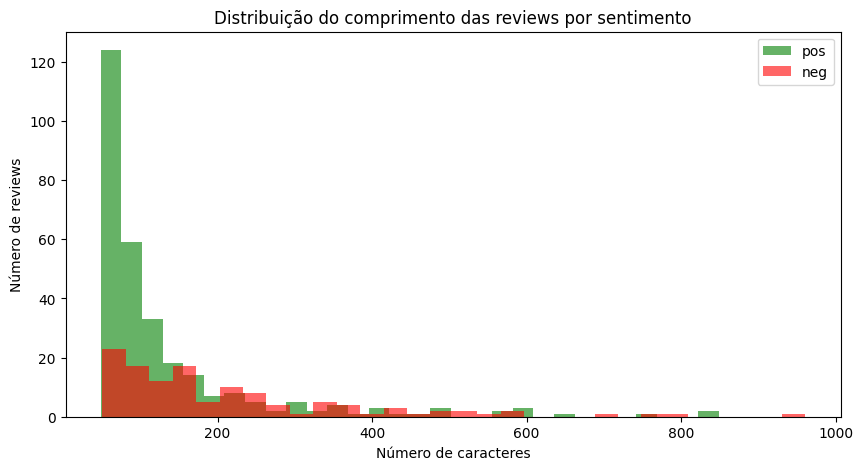


Exemplo de review positiva:
Atende aos objetivos por sua portabilidade e recursos

Exemplo de review negativa:
netbook  muito ruim pequeno programação ruim  windo 10 muito ruim.

Review mais longa:
sentiment                                                    neg
review_text    O produto n chegou em minha residência já vai ...
Name: 317, dtype: object

Review mais curta:
sentiment                                                    pos
review_text    ESTOU MUITO SATISFEITO COM ATENDIMENTO <empresa>!
Name: 103, dtype: object


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#Ler o ficheiro notebooks-challenge.csv criado pelo classificador
df = pd.read_csv('data/notebooks-challenge.csv')

# Estatísticas básicas
print("Total de reviews:", len(df))
print("Distribuição de sentimentos:")
print(df['sentiment'].value_counts())
print("\nComprimento médio das reviews por sentimento:")
df['review_length'] = df['review_text'].str.len()
print(df.groupby('sentiment')['review_length'].mean())

# Histograma do comprimento das reviews
plt.figure(figsize=(10,5))
for s, color in zip(['pos', 'neg'], ['green', 'red']):
    subset = df[df['sentiment'] == s]
    plt.hist(subset['review_length'], bins=30, alpha=0.6, label=s, color=color)
plt.xlabel('Número de caracteres')
plt.ylabel('Número de reviews')
plt.title('Distribuição do comprimento das reviews por sentimento')
plt.legend()
plt.show()

# Exemplos de reviews positivas e negativas
print("\nExemplo de review positiva:")
print(df[df['sentiment'] == 'pos']['review_text'].sample(1).values[0])
print("\nExemplo de review negativa:")
print(df[df['sentiment'] == 'neg']['review_text'].sample(1).values[0])

# Reviews mais longas e mais curtas
print("\nReview mais longa:")
print(df.loc[df['review_length'].idxmax(), ['sentiment', 'review_text']])
print("\nReview mais curta:")
print(df.loc[df['review_length'].idxmin(), ['sentiment', 'review_text']])


### Tentativa de usar Llama-3.1-8B - sem sucesso

In [ ]:
import pandas as pd
from transformers import pipeline

# Carregar os dados do desafio
challenge_data = pd.read_csv("data/notebooks-challenge.txt", sep="\t")

# Inicializar o classificador de sentimentos
classifier = pipeline("text-classification", model="meta-llama/Llama-3.1-8B-Instruct")

# Classificar os dados do desafio
challenge_data["sentiment"] = challenge_data["review_text"].apply(
    lambda x: classifier(x, candidate_labels=["pos", "neg"])[0]["label"]
)

# Guardar os resultados num ficheiro CSV
challenge_data.to_csv("notebook-challenge.csv", columns=["sentiment", "review_text"])


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.1-8B-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use mps:0


RuntimeError: MPS backend out of memory (MPS allocated: 18.00 GB, other allocations: 384.00 KB, max allowed: 18.13 GB). Tried to allocate 224.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [ ]:
# Carregar o CSV com os resultados
dev_data = pd.read_csv("notebook-devel.csv")

# Inicializar o classificador de sentimentos
predicted_labels = [classifier(text) for text in dev_data["review_text"]]
print(f"Accuracy: {accuracy_score(dev_data['sentiment'], predicted_labels):.2f}")